In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 850.6 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_rdqqj1h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_rdqqj1h
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.2.1+cu121


In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 155MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
import pandas as pd
import requests
import io
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import clip
import os


In [ ]:
# Load your dataset
data = pd.read_json("/content/filtered_train.json")
texts = [entry['text'] for entry in data['pairs']]
images = [entry['image'] for entry in data['pairs']]

In [ ]:
yes_no_count=[entry['subtask1_label'] for entry in data['pairs']]
lang_count=[entry['language'] for entry in data['pairs']]

In [ ]:
yes_count = yes_no_count.count('YES')
no_count = yes_no_count.count('NO')
unique_lang_count = len(set(lang_count))

print(f"Total number of 'yes' labels: {yes_count}")
print(f"Total number of 'no' labels: {no_count}")
print(f"Total unique languages: {unique_lang_count}")



Total number of 'yes' labels: 65
Total number of 'no' labels: 198
Total unique languages: 4


In [ ]:
lang_count = [entry['language'] for entry in data['pairs']]
unique_lang_count = len(set(lang_count))

lang_row_count = {}
for lang in set(lang_count):
    lang_row_count[lang] = lang_count.count(lang)

print("Rows per unique language:")
for lang, count in lang_row_count.items():
    print(f"{lang}: {count} rows")


Rows per unique language:
it: 123 rows
fr: 27 rows
en: 110 rows
de: 3 rows


In [ ]:
# Load CLIP model and preprocess data
clip.available_models()
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
max_length=[max(i) for i in texts]

In [ ]:
len(max_length)

263

In [ ]:
# Preprocess images and texts
preprocessed_images = []
for image_url in images:
    response = requests.get(image_url)
    image = Image.open(io.BytesIO(response.content)).convert("RGB")
    preprocessed_images.append(preprocess(image))

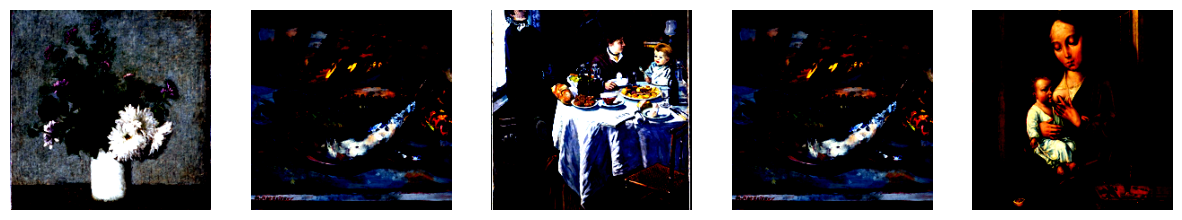

In [ ]:
# Display the first five preprocessed images
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i, image in enumerate(preprocessed_images[:num_images_to_display]):
    axes[i].imshow(image.permute(1, 2, 0))  # Permute dimensions for display
    axes[i].axis("off")

plt.show()

In [ ]:
# Define a custom CLIP tokenizer function
def custom_clip_tokenize(texts, context_length):
    # Tokenize texts using the CLIP tokenizer
    tokenized_texts = [clip.tokenize(text, context_length=context_length) for text in texts]
    return torch.cat(tokenized_texts, dim=0)


In [ ]:
# Modify the input texts to fit within the context length
max_context_length = 77  # Assuming this is the context length used by CLIP
texts_trimmed = [text[:max_context_length] for text in texts]

In [ ]:
# Define the maximum context length based on the CLIP model
max_context_length = model.context_length

# Trim the texts to fit within the context length
texts_trimmed = [text[:max_context_length] for text in texts]

# Tokenize trimmed texts using the custom tokenizer function
text_tokens = custom_clip_tokenize(texts_trimmed, max_context_length).cuda()


In [ ]:
image_input = torch.tensor(np.stack(preprocessed_images)).cuda()

In [ ]:
# tokenized_texts = [clip.tokenize(text) for text in trimmed_texts]

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [ ]:
import torch


In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

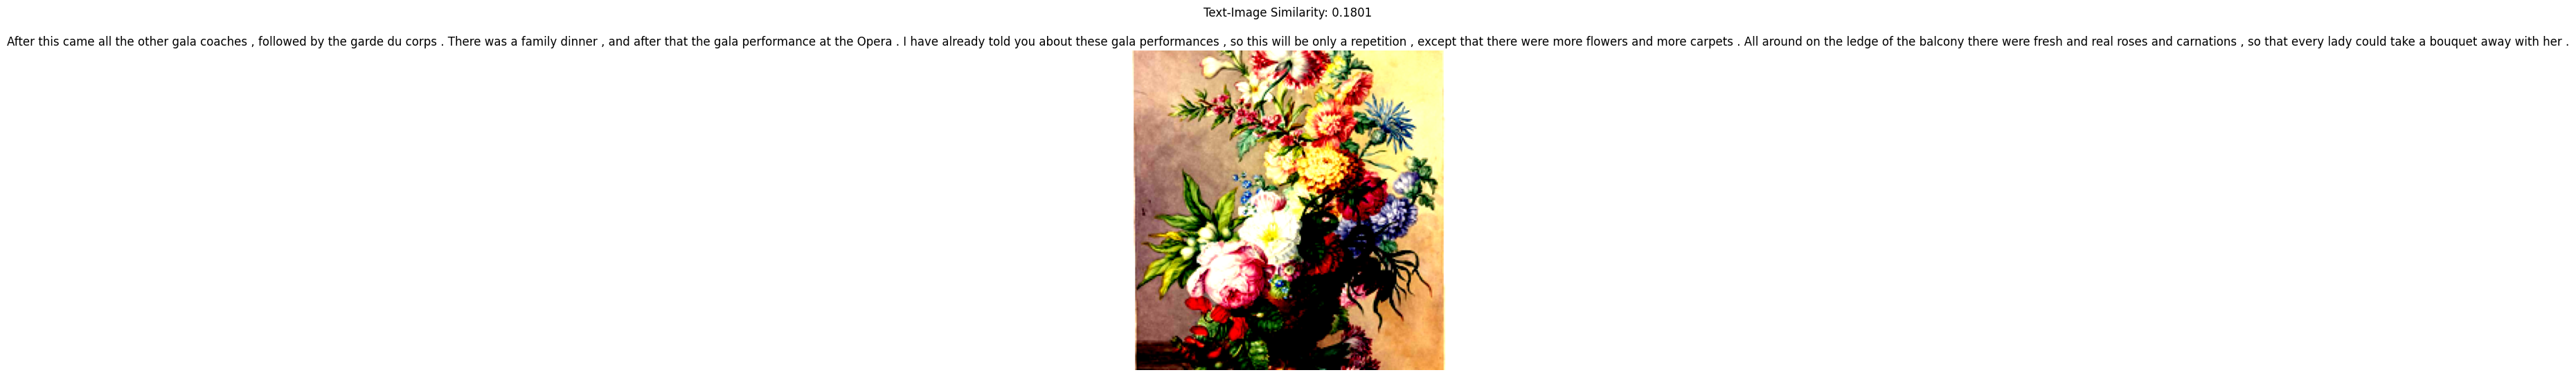

In [ ]:
# Choose the index of the text and image pair you want to visualize
pair_index = 5  # Change this to the index of the pair you want to visualize

# Extract the similarity score for the chosen pair
chosen_similarity = similarity[pair_index, 5]  # Assuming the image is at index 0 for the chosen pair

# Display the text and image pair along with their similarity score
chosen_text = texts[pair_index]
chosen_image = preprocessed_images[pair_index]

# Display the text and image along with their similarity score
plt.figure(figsize=(8, 6))
plt.imshow(chosen_image.permute(1, 2, 0))  # Permute dimensions for display
plt.title(f"Text-Image Similarity: {chosen_similarity:.4f}\n\n{texts[pair_index]}")
plt.axis("off")
plt.show()


In [ ]:
# Define a threshold for similarity to determine "YES" and "NO" predictions
threshold = 0.5  # Adjust the threshold as needed

# Define the actual labels from the dataset
actual_labels = [entry['subtask1_label'] for entry in data['pairs']]

# Calculate the predicted labels based on the similarity matrix and threshold
predicted_labels = ['YES' if sim > threshold else 'NO' for sim in similarity.diagonal()]

# Calculate accuracy
correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
accuracy = correct_predictions / len(actual_labels) * 100

print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 75.29%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Extract the actual labels from your dataset
actual_labels = [entry['subtask1_label'] for entry in data['pairs']]

# Define the threshold and calculate predicted labels
threshold = 0.2
predicted_labels = ['YES' if sim > threshold else 'NO' for sim in similarity.diagonal()]

# Calculate true positives (TP), false positives (FP), true negatives (TN), false negatives (FN)
TP = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == 'YES' and predicted == 'YES')
FP = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == 'NO' and predicted == 'YES')
TN = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == 'NO' and predicted == 'NO')
FN = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == 'YES' and predicted == 'NO')

# Calculate precision, recall, and F1 score
precision = precision_score(actual_labels, predicted_labels, pos_label='YES')
recall = recall_score(actual_labels, predicted_labels, pos_label='YES')
f1 = f1_score(actual_labels, predicted_labels, pos_label='YES')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.33
Recall: 0.69
F1 Score: 0.45


In [ ]:
print(TP)

45


In [ ]:
print(TN)

107


In [ ]:
print(FP)

91


In [ ]:
print(FN)

20


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Adjust the threshold value
threshold = 0.5  # Adjust this threshold value as needed

# Calculate predicted labels based on the adjusted threshold
predicted_labels = ['YES' if sim > threshold else 'NO' for sim in similarity.diagonal()]

# Calculate precision, recall, and F1 score
precision = precision_score(actual_labels, predicted_labels, pos_label='YES')
recall = recall_score(actual_labels, predicted_labels, pos_label='YES')
f1 = f1_score(actual_labels, predicted_labels, pos_label='YES')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
